# Decision Tree

In [23]:
import pandas as pd, numpy as np, math, itertools, graphviz

In [24]:
restaurant_df = pd.read_csv('datasets/restaurant.csv')
weather_df = pd.read_csv('datasets/weather.csv')
iris_df = pd.read_csv('datasets/iris.csv')
connect4_df = pd.read_csv('datasets/connect4.csv')

Abaixo está definida uma classe genérica para o pré-processamento de qualquer dataset. Onde estão definidos alguns atributos úteis:
* self.dataset: Para guardar o dataset que será posteriormente tratado;
* self.codification: Um dicionário que poderemos consultar para saber como codificar uma próxima sample;
* self.continuous_features: Lista para guardar as features contínuas do dataset;
* self.categoric_features: Lista para guardar as features categóricas do dataset;
* self.target: Para guardar o nome da classe;
* self.train: Dataset de treino;
* self.test: Dataset de teste;

Quanto aos métodos:
* header: Acrescentar header para o connect4;
* to_numeric: Para transformar uma feature categórica não numérica para numérica;
* get_insert_position: Para obter onde se deve inserir um valor de uma feature contínua que foi discretizada;
* eq_frequency: Para discretizar uma feature contínua, fazendo com que cada categoria tenha o mesmo número de elementos;
* eq_interval_width: Para discretizat uma feature contínua, fazendo com  que cada categoria tenha a mesma largura;
* subsets: Divide em vários datasets com uma feature específica e um valor de target específico;
* stratify: Divide o dataset em teste e treino;
* leave_one_out: Método de cross validation, onde uma dos samples estão está sempre de foram enquanto se usa o resto para o treinamento;
* prepare_dataset: Processa todo o dataset, colocando-o pronto para ser utilizado pelo modelo;
* prepare_row: Prepara uma nova sample fornecida, no caso de se querer usar no modelo preditivo;

In [25]:
class PreprocessData:
    def __init__(self, dataset: pd.DataFrame) -> None:
        self.dataset = dataset.copy()
        self.codification = {}
        self.continuous_features = []
        self.categoric_features = []
        self.target = self.dataset.columns[-1]
        self.train = None
        self.test = None
    
    # Header para o connect4
    def header(self):
        indice = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'Class']

        self.dataset.columns = indice
        self.target = indice[-1]

    #Cat to numeric
    def to_numeric(self, feature: str) -> None:
        feature_dic = {value: idx for idx, value in enumerate(set(self.dataset[feature].values))} #guardar a codificação para depois poder fazer predict
        new_column = [feature_dic[row[feature]] for _, row in self.dataset.iterrows()] #nova coluna codificada
        self.dataset[feature] = new_column
        self.codification[feature] = feature_dic #guardar a codificação na classe

    #Cont to Discrete
    def get_insert_position(self, l: list, value) -> int:
        for idx, i in enumerate(l):
            if value <= i:
                return idx
        return len(l)
    
    def eq_frequency(self, n_classes: int, feature: str) -> None:
        split_values = [] #valores onde dar split
        
        #descobre quartis
        for i in range(1, n_classes):
            quantil = (i / n_classes) * 100 
            split_value = np.percentile( self.dataset[feature] , quantil )
            split_values.append(split_value)
            
        #lista com os valores das novas classes para cada sample
        new_column = [self.get_insert_position(split_values, row[feature]) for _, row in self.dataset.iterrows()]
        
        self.dataset[feature] = new_column

        feature_dic = {}
        
        for idx, split_value in enumerate(split_values):
            
            if idx == 0:
                feature_dic[ idx ] = [float('-inf'), split_value]
                
            elif idx == len(split_values) - 1:
                feature_dic[ idx ] = [split_values[idx - 1], split_value]
                feature_dic[ idx + 1 ] = [split_value, float('inf')]

            else:
                feature_dic[ idx ] = [split_values[idx - 1], split_value]
        
        self.codification[ feature ] = ['eq_frequency', feature_dic]

    def eq_interval_width(self, n_classes: int, feature: str) -> None:
        min = self.dataset[feature].min()
        max = self.dataset[feature].max()
        width = (max - min) / n_classes
        
        split_values = [min + i * width for i in range(1, n_classes)]
        
        new_column = [self.get_insert_position(split_values, row[feature]) for _, row in self.dataset.iterrows()]
        
        self.dataset[feature] = new_column
        
        feature_dic = {}
        
        for idx, split_value in enumerate(split_values):
            
            if idx == 0:
                feature_dic[ idx ] = [float('-inf'), split_value]
                
            elif idx == len(split_values) - 1:
                feature_dic[ idx ] = [split_values[idx - 1], split_value]
                feature_dic[ idx + 1 ] = [split_value, float('inf')]

            else:
                feature_dic[ idx ] = [split_values[idx - 1], split_value]
        
        self.codification[ feature ] = ['eq_interval_width', feature_dic]
    
    #divide em treino e teste
    def subsets(self, target: str) -> list:
        return [np.random.choice(self.dataset[self.dataset[target] == i].index.values.tolist(), size=len(self.dataset[self.dataset[target] == i]), replace=False) for i in self.dataset[target].unique()]

    def stratify(self, perc: float) -> None: 
        sample_test = math.ceil(perc * self.dataset.shape[0]) #calcula tamanho do test_df

        values_prop = self.dataset[self.target].value_counts(normalize= True) * sample_test 
        quantidade = values_prop.map(round) #nº de valores do target presente no test_df para manter proporçao
        
        values_sub = self.subsets(self.target)
        #listas para guardar indices dos valores de teste e treino
        acc_test = [] 
        acc_train = []
        for i in range(len(quantidade)):
            quant = quantidade[i]
            acc_test.append(values_sub[i][:quant])
            acc_train.append(values_sub[i][quant : ])
            
        #listas com os indices
        list_test = list(itertools.chain.from_iterable(acc_test))
        list_train = list(itertools.chain.from_iterable(acc_train))
        acc_test = np.random.choice(list_test, size = len(list_test), replace=False)
        acc_test, exc = acc_test[:sample_test], acc_test[sample_test:]
        list_train.extend(exc)
        self.test = self.dataset.iloc[acc_test]
        self.train = self.dataset.iloc[list_train]

    #leave one out
    def leave_one_out(self): 
        acc = []
        for i in range(len(self.dataset)):
            train = pd.concat([self.dataset.iloc[:i], self.dataset.iloc[i+1:]])
            test = self.dataset.iloc[[i]]
            acc.append((train, test))
        return acc #lista de tuplos (dataset_train, dataset_test)

    #prepara o dataset para a arvore
    def prepare_dataset(self, n_classes: int= 3, func= None) -> None:
        if 'ID' in self.dataset.columns:
            self.dataset = self.dataset.drop('ID', axis= 1)
        # self.to_numeric(self.target)
        for feature in self.dataset.columns:
            if self.dataset[feature].dtype == float or self.dataset[feature].dtype == 'int64': #cont
                self.continuous_features.append(feature)
                func(n_classes, feature)

            elif self.dataset[feature].dtype == object or self.dataset[feature].dtype == bool: #cat
                self.categoric_features.append(feature)
                self.to_numeric(feature= feature)

    #prepara uma linha para ser usada na previsão
    def prepare_row(self, row: pd.Series):
        new_row = []
        for feature, value in row.items():
            
            if feature in self.continuous_features:
                type_cod, dic = self.codification[feature]

                for cls, interval in dic.items():
                    if value > interval[0] and value <= interval[1]:
                        new_row.append( cls )
                        break
            
            elif feature in self.categoric_features:
                dic = self.codification[feature]
                new_row.append( dic.get(value) )
        return new_row

# Node

A classe abaixo define o nó que irá ser usado para contruir a árvore de decisão. É de notar algumas especificidades de alguns atributos:
* A raiz da árvore apenas terá definido o atributo self.feature;
* As folhas da árvore terão definidos self.leaf_value e self.condition;
* Os restantes terão definidos todos os atributos exceto self.leaf_value;
* É importante ressaltar que o atributo self.condition refere-se ao atributo do nó anterior, daí não existir na raiz da árvore;

In [26]:
class Node:
    def __init__(self, feature: int= None, condition: int = None, children: list= [], info_gain: float= None, leaf_value: int= None) -> None:
        #nós de decisão
        self.feature = feature
        self.children = children
        self.info_gain = info_gain
        
        #folhas
        self.leaf_value = leaf_value
        
        #todos os nós menos a raiz
        self.condition = condition
    
    def add_child(self, child) -> None:
        self.children.append(child)
        
    def set_condition(self, condition: int) -> None:
        self.condition = condition

    def is_leaf(self) -> bool:
        return len(self.children) == 0

    def __str__(self) -> str:
        return 'Feature: ' + self.feature + '| Filhos: ' + str(len(self.children))

# Decision Tree Classifier

Nesta classe definimos a árvore de decisão. Os seus atributos são:
* self.root: Que será a raiz;
* self.target: Para guardar a classe target;
* self.gain: Serve para guardar qual função quereremos usar para fazer a avaliação da melhor feature a usar a cada nível da árvore;
* self.original_dataset: Serve apenas para guardar o primeiro dataset usado (útil para a criação de folhas que não estejam presentes no dataset do momento, mas que possam existir noutra sample);

Já nos métodos temos:
* same_class: Avalia se todas as samples pertencem à mesma classe target;
* build_tree: Constrói a árvore ID3 por recursão;
* entropy_df: Obtém a entropia do dataset completo;
* entropy_class: Obtém a entropia para cada classe de uma determinada feature;
* entropy_split: Obtém a entropia para uma determinada feature;
* info_gain: Determina o ganho de infomação para uma determinada feature;
* max_info_gain: Retorna a feature com o melhor ganho de informação;
* gini_class: Obtém o gini para cada classe de uma determinada feature;
* gini_split: Obtém o gini para uma determinada feature;
* max_gini: Retorna a feature com o melhor índice gini;
* get_best_split: Retorna um dicionário com:
    * Feature com a qual foi feita o split do dataset;
    * Ganho de informação obtido pela feature escolhida;
    * Datasets filhos, provenientes do split considerando a feature com o melhor ganho;
* calculate_leaf_value: Obtém o plurality value de um dataset;
* fit: Inicializa todo o processo de contrução da árvore, tal e qual o sklearn;
* predict: Dado um dataset X, retorna as previsões da classe target feitas usando a árvore de decisão criada previamente;
* make_prediction: Dada uma linha x, faz-se também a previsão da classe target;
* print_tree: Imprime um esboço da árvore no próprio terminal;

In [27]:
class DecisionTreeClassifier:
    def __init__(self) -> None:
        self.root = None
        self.target = None
        self.gain = None
        self.original_dataset = None
        
    #avalia se todos os valores do target são iguais
    def same_class(self, dataset: pd.DataFrame) -> bool:
        return dataset[self.target].value_counts().max() == dataset.shape[0]
        
    def build_tree(self, dataset: pd.DataFrame, remaining_features: list, parent_dataset: pd.DataFrame) -> Node:
        y = dataset[self.target]
        
        #sem samples restantes
        if dataset.shape[0] == 0:
            return Node(leaf_value= self.calculate_leaf_value( parent_dataset[ self.target ] ))
        
        #todas as samples são da mesma classe
        elif self.same_class(dataset= dataset):
            return Node(leaf_value= self.calculate_leaf_value( dataset[ self.target ] ))
        
        #sem atributos restantes
        elif len(remaining_features) == 0:
            return Node(leaf_value= self.calculate_leaf_value( dataset[ self.target ] ))
            
        else:
            best_split = self.get_best_split(dataset= dataset, features= remaining_features) # dict com feature, info_gain, k: k_dataset
            remaining_features.remove( best_split['feature'] )
            
            children = []    
            for value, child_dataset in best_split['datasets'].items():
                subtree = self.build_tree(dataset= child_dataset, remaining_features= remaining_features, parent_dataset= dataset)
                subtree.set_condition(value) #o valor é a condição referente à feature do pai

                children.append(subtree)
                
            return Node(feature= best_split['feature'], info_gain= best_split['info_gain'], children= children)
         
    #Cálculo do info gain com entropia
    def entropy_df(self, dataset: pd.DataFrame) -> float:
        dataset = dataset[self.target]
        if len(dataset) == 0 or len(dataset.unique()) == 1: #Caso o dataset seja vazio ou com valor unico
            return 0
        # Vectorized implementation for efficiency using `groupby` and weighted entropy calculation
        value_counts = dataset.value_counts(normalize=True)
        entropy = -(value_counts * np.log2(value_counts)).sum()
        return entropy
    
    def entropy_class(self, dataset: pd.DataFrame, feature: str) -> dict:
        values_target = dataset[self.target].unique()
        values_feature = dataset[feature].unique()
        entropy_dic = {}
        
        for val in values_feature:
            entropy_val = 0
            for j in values_target:
                subset = dataset[(dataset[feature] == val) & (dataset[self.target] == j)]
                prob = len(subset) / len(dataset[dataset[feature] == val])
                if prob > 0:
                    entropy_val -= prob * np.log2(prob)
            entropy_dic[val] = entropy_val
        
        return entropy_dic
    
    def entropy_split(self, dataset: pd.DataFrame, feature: str) -> float:
        dic = self.entropy_class(dataset, feature)
        values = dic.keys()
        soma = 0
        tamanho = len(dataset[feature])
        for i in values:
            soma += (len(dataset[dataset[feature] == i])/tamanho) * dic[i]
        return soma
    
    def info_gain(self, dataset: pd.DataFrame, feature: str) -> float:
        return self.entropy_df(dataset) - self.entropy_split(dataset, feature)
    
    def max_info_gain(self, dataset: pd.DataFrame, features: list) -> tuple:
        info_gains = [self.info_gain(dataset= dataset, feature= feature) for feature in features]
        max_info_gain = max(info_gains)
        return (features[ info_gains.index(max_info_gain) ], max_info_gain)
    
    #Cálculo de gini
    def gini_class(self, dataset: pd.DataFrame, feature: str) -> dict: # Calcula o indice gini de cada valor em uma feature e retorna um dicionario com cada valor e seu respectivo resultado
        values_target = dataset[self.target].unique()
        values_feature = dataset[feature].unique()
        gini_dic = {}
        for val in values_feature:
            soma = 1
            for j in values_target:

                tamanho_val_feature = len(dataset[dataset[feature]== val])
                    
                a = dataset[(dataset[feature]== val) & (dataset[self.target] == j)].shape[0]
                soma -= (a/tamanho_val_feature)**2
            gini_dic[val] = soma
        return gini_dic

    def gini_split(self, dataset: pd.DataFrame, feature: str) -> float: # calcula o indice gini total da feature 
        dic = self.gini_class(dataset, feature)
        values = dic.keys()
        soma = 0
        tamanho = len(dataset[feature])
        for i in values:
            soma += (len(dataset[dataset[feature] == i])/tamanho) * dic[i]
        return soma

    def max_gini(self, dataset: pd.DataFrame, features: list) -> tuple: # (feature, max_gini)
        ginis = [self.gini_split(dataset, feature) for feature in features]
        final_gini = min(ginis)
        return (features[ ginis.index(final_gini) ], final_gini)
    
    #obtem o melhor split de dados
    def get_best_split(self, dataset: pd.DataFrame, features: list) -> dict: #dict com feature, info_gain e k: k_dataset
        feature, info_gain = self.gain(dataset, features)
        
        feature_values = self.original_dataset[feature].unique() #valores do original para haver sempre todos os ramos na arvore

        child_datasets = {}
        for value in feature_values: #separa em datasets filhos para cada valor da feature
            child_dataset = dataset[dataset[feature] == value]
            child_datasets[value] = child_dataset
            
        best_split = {}
        best_split['feature'] = feature
        best_split['info_gain'] = info_gain
        best_split['datasets'] = child_datasets
        return best_split
    
    #obtem o valor de folha mais comum
    def calculate_leaf_value(self, y: pd.DataFrame) -> int:
        y = list(y)
        return max(y, key= y.count)
    
    #construçao da DT
    def fit(self, process: PreprocessData, option) -> None: #option é self.max_info_gain ou self.max_gini
        self.gain = option
        self.original_dataset = process.dataset
        features, self.target = process.train.columns.to_list()[:-1], process.train.columns[-1]
        self.root = self.build_tree(dataset= process.train, remaining_features= features, parent_dataset= process.train)
        
    def predict(self, X: pd.DataFrame) -> list:
        l = []
        for _, row in X.iterrows():
            pred = self.make_prediction(row, self.root)
            l.append(pred)
        return l
    
    def make_prediction(self, x: pd.Series, node: Node) -> int:
        if node.is_leaf(): 
            return node.leaf_value
        feature_value = x[node.feature]
        for child in node.children:
            if feature_value == child.condition:
                return self.make_prediction(x, child)
        # print(x)
        # print('No prediction')

    def print_tree(self, node: Node= None, indent= ""):
        if node is None:
            node = self.root
            
        if node.leaf_value is not None:
            print(indent + "Condition: " + str(node.condition) + "|   Leaf Value: ", node.leaf_value)
            return
        elif node.condition is None:
            print(indent + "Feature: " + node.feature)
        else:
            print(indent + "Condition: " + str(node.condition) + "|   Feature: " + node.feature)
        for child in node.children:
            self.print_tree(child, indent + "   ")

# Statistics

Esta classe serve para obtermos alguns dados úteis para avaliar a qualidade da nossa árvore. Os seus métodos são:
* evaluate_binary: Usada para datasets nos quais a classe target é binária. Retorna precisão, exatidão, recall, F1 score e matriz de dispersão;
* evaluate_non_binary: Usada em datasets nos quais a classe target não é binária. Retorna precisão, exatidão e recall;
* evaluate_once: Usado para avaliar uma certa árvore feita a partir de um certo dataset;
* evaluate_n_times: Usado para fazer uma média de todas as estatísticas, gerando n árvores diferentes para fazer;
* evaluate_loo: Calculos estísitcos para o caso LOO;

In [28]:
class Statistics:
    def __init__(self) -> None:
        pass
    
    #funçoes para PRECISION, ACCURACY, RECALL
    def binary(self, y_test, y_pred) -> tuple:
        positive_label = 1
        negative_label = 0
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        recall = 0
        precision = 0
        accuracy = 0

        for idx, pred in enumerate(y_pred):
            if pred == positive_label:
                if y_test[ idx ] == positive_label:
                    TP += 1
                if y_test[ idx ] == negative_label:
                    FP += 1
            elif pred == negative_label:
                if y_test[ idx ] == negative_label:
                    TN += 1
                elif y_test[ idx ] == positive_label:
                    FN += 1
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        accuracy = (TP + TN) /(TP + TN + FP + FN)
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1_score = (2 * precision * recall)/(precision + recall) if precision + recall > 0 else 0
        return precision, recall, accuracy, f1_score, str(TP) + '|' + str(FN) + '\n -+-\n ' + str(FP) + '|' + str(TN)
    
    def non_binary(self, y_test: list, y_pred: list) -> tuple:
        pred_values = set(y_pred)
        
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        recall = 0
        precision = 0
        accuracy = 0
        
        for value in pred_values:
            TP = 0
            FP = 0
            TN = 0
            FN = 0
            for idx, pred in enumerate(y_pred):
                if pred == value:
                    if y_test[ idx ] == value: TP += 1
                    else: FP += 1
                else:
                    if y_test[ idx ] == value: FN += 1
            recall += TP / (TP + FN) if TP + FN > 0 else 0
            precision += TP / (TP + FP) if TP + FP > 0 else 0
            accuracy += (TP + TN) / (TP + TN + FP + FN)
        return precision / len(pred_values), recall / len(pred_values), accuracy / len(pred_values)
    
    #Avaliação simples usando train e test split normal
    def evaluate_once(self, tree: DecisionTreeClassifier, process: PreprocessData) -> None:
        test = process.test
        target = process.target
        x_test = test[ test.columns[:-1] ]
        y_test = test[ target ].to_list()
        y_pred = tree.predict(x_test)
        
        print('Test values: ' + str(y_test))
        print('Pred values: ' + str(y_pred))
        
        if len( set(process.dataset[ target ].values) ) == 2:
            precision, recall, accuracy, f1_score, confusion_matrix= self.binary(y_test= y_test, y_pred= y_pred)
            print('Precision: ' + str(precision))
            print('Recall: ' + str(recall))
            print('Accuracy: ' + str(accuracy))
            print('F1 Score: ' + str(f1_score))
            print('Confusion Matrix: \n ' + confusion_matrix)
            
        else:
            precision, recall, accuracy = self.non_binary(y_test= y_test, y_pred= y_pred)
            print('Precision: ' + str(precision))
            print('Recall: ' + str(recall))
            print('Accuracy: ' + str(accuracy))
    
    '''
        dataset: 1- restaurant, 2- weather, 3- iris, 4- connect4
        f: 1- eq_frequency, 2- eq_interval_width
        gain: 1- max_info_gain, 2- max_gini
    '''
    def evaluate_n_times(self, dataset: int, n: int, n_classes: int, f: int, gain: int, perc: float= 0.2):
        precisions = []
        recalls = []
        accuracies = []
        for _ in range(n):
            datasets = [restaurant_df, weather_df, iris_df, connect4_df]

            process = PreprocessData(dataset= datasets[dataset - 1])
            funcs = [process.eq_frequency, process.eq_interval_width]
            process.prepare_dataset(n_classes= n_classes, func= funcs[f - 1])
            process.stratify(perc)

            dt = DecisionTreeClassifier()
            gains = [dt.max_info_gain, dt.max_gini]
            dt.fit(process= process, option= gains[ gain - 1 ])
            
            test = process.test
            target = process.target
            x_test = test[ test.columns[:-1] ]
            y_test = test[ target ].to_list()
            y_pred = dt.predict(x_test)
            
            if len( set(process.dataset[ target ].values) ) == 2:
                precision, recall, accuracy, *_ = self.binary(y_test= y_test, y_pred= y_pred)
            else:
                precision, recall, accuracy = self.non_binary(y_test= y_test, y_pred= y_pred)
            
            precisions.append(precision)
            recalls.append(recall)
            accuracies.append(accuracy)
            
        stats = pd.DataFrame({'precision': precisions,
                              'recall': recalls,
                              'accuracy': accuracies
                              })
        return stats.mean()
    
    def evaluate_loo(self, process: PreprocessData) -> float:
        loo = process.leave_one_out()
        y_true, y_pred = [], []
        for train, test in loo:
            process.train = train
            process.test = test
            
            dt = DecisionTreeClassifier()
            dt.fit(process=process, option=dt.max_info_gain)
            
            y_pred.append(dt.predict(test[test.columns[:-1]])[0])
            y_true.append(test[test.columns[-1]].values[0])
        
        if len(y_true) != len(y_pred):
            raise ValueError("As listas devem ter o mesmo comprimento")
        
        correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
        
        accuracy = correct / len(y_true)
        
        precision, recall, accuracy, f1_score, confusion_matrix= self.binary(y_test= y_true, y_pred= y_pred)
        print('Precision: ' + str(precision))
        print('Recall: ' + str(recall))
        print('Accuracy: ' + str(accuracy))
        print('F1 Score: ' + str(f1_score))
        print('Confusion Matrix: \n ' + confusion_matrix)

# Visualization

A função abaixo serve para uma melhor visualização da árvore.

In [29]:
def visualize_tree(tree: Node, target_name: str, label_names):
    leaf_names = label_names[target_name]

    def format_interval(interval):
        return f"[{interval[0]:.1f}, {interval[1]:.1f}]"

    def get_label(parent_feature, edge_label):
        if isinstance(label_names[parent_feature], list):
            # Handle intervals
            intervals = label_names[parent_feature][1]
            edge_label_int = int(edge_label.split()[-1])
            interval = intervals[edge_label_int]
            return format_interval(interval)
        else:
            # Handle categorical values
            value_dict = label_names[parent_feature]
            edge_label_int = int(edge_label.split()[-1])
            label = [key for key, value in value_dict.items() if value == edge_label_int]
            return f"{label[0]}" if label else edge_label

    def traverse(node: Node, graph, parent_name=None, edge_label="", parent=None):
        node_id = str(id(node))
        if node.is_leaf():
            node_label = f"Class: {[chave for chave, valor in leaf_names.items() if valor == node.leaf_value][0]}"
            node_color = 'lightblue'
        else:
            node_label = f"{node.feature}\nIG: {node.info_gain:.1f}"
            node_color = 'red'

        graph.node(node_id, label=node_label, style='filled', fillcolor=node_color, shape='box')

        if parent_name:
            label = get_label(parent.feature, edge_label)
            graph.edge(parent_name, node_id, f"= {label}", color='black')

        for child in node.children:
            traverse(child, graph, node_id, f"= {child.condition}", node)

    dot = graphviz.Digraph()
    traverse(tree, dot)
    return dot

# Árvores aplicado aos datasets

Árvore para o dataset "restaurant":

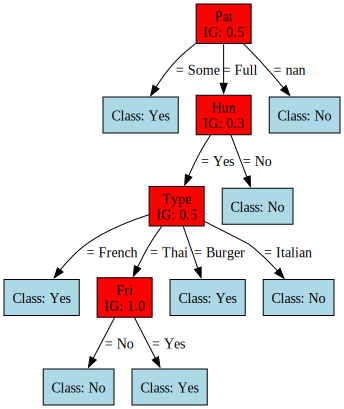

In [21]:
restaurant_process = PreprocessData(dataset= restaurant_df)
restaurant_process.prepare_dataset(n_classes= 3, func= restaurant_process.eq_frequency)
restaurant_process.stratify(0)
restaurant_cod = restaurant_process.codification

restaurant_dt = DecisionTreeClassifier()
restaurant_dt.fit(process= restaurant_process, option= restaurant_dt.max_info_gain)

restaurant_dot = visualize_tree(restaurant_dt.root, restaurant_dt.target, restaurant_cod)
restaurant_dot.render('pngs/restaurant_decision_tree', format='png', cleanup=True)
restaurant_dot

Árvore para o dataset "Weather".

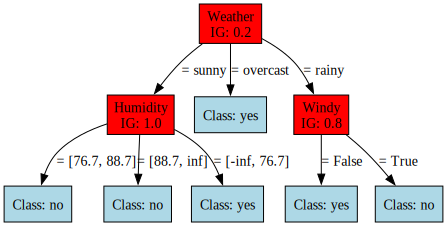

In [22]:
weather_process = PreprocessData(dataset= weather_df)
weather_process.prepare_dataset(n_classes= 3, func= weather_process.eq_frequency)
weather_process.stratify(0.2)
weather_cod = weather_process.codification

weather_dt = DecisionTreeClassifier()
weather_dt.fit(process= weather_process, option= weather_dt.max_info_gain)

weather_dot = visualize_tree(weather_dt.root, weather_dt.target, weather_cod)
weather_dot.render('pngs/weather_decision_tree', format='png', cleanup=True)
weather_dot

Árvore para o dataset "iris".

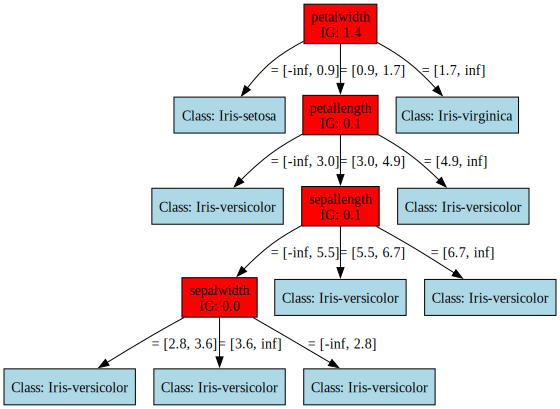

In [23]:
iris_process = PreprocessData(dataset= iris_df)
iris_process.prepare_dataset(n_classes= 3, func= iris_process.eq_interval_width)
iris_process.stratify(0.2)
iris_cod = iris_process.codification

iris_dt = DecisionTreeClassifier()
iris_dt.fit(process= iris_process, option= iris_dt.max_info_gain)

iris_dot = visualize_tree(iris_dt.root, iris_dt.target, iris_cod)
iris_dot.render('pngs/iris_decision_tree', format='png', cleanup=True)
iris_dot

Árvore para o dataset "connect4".

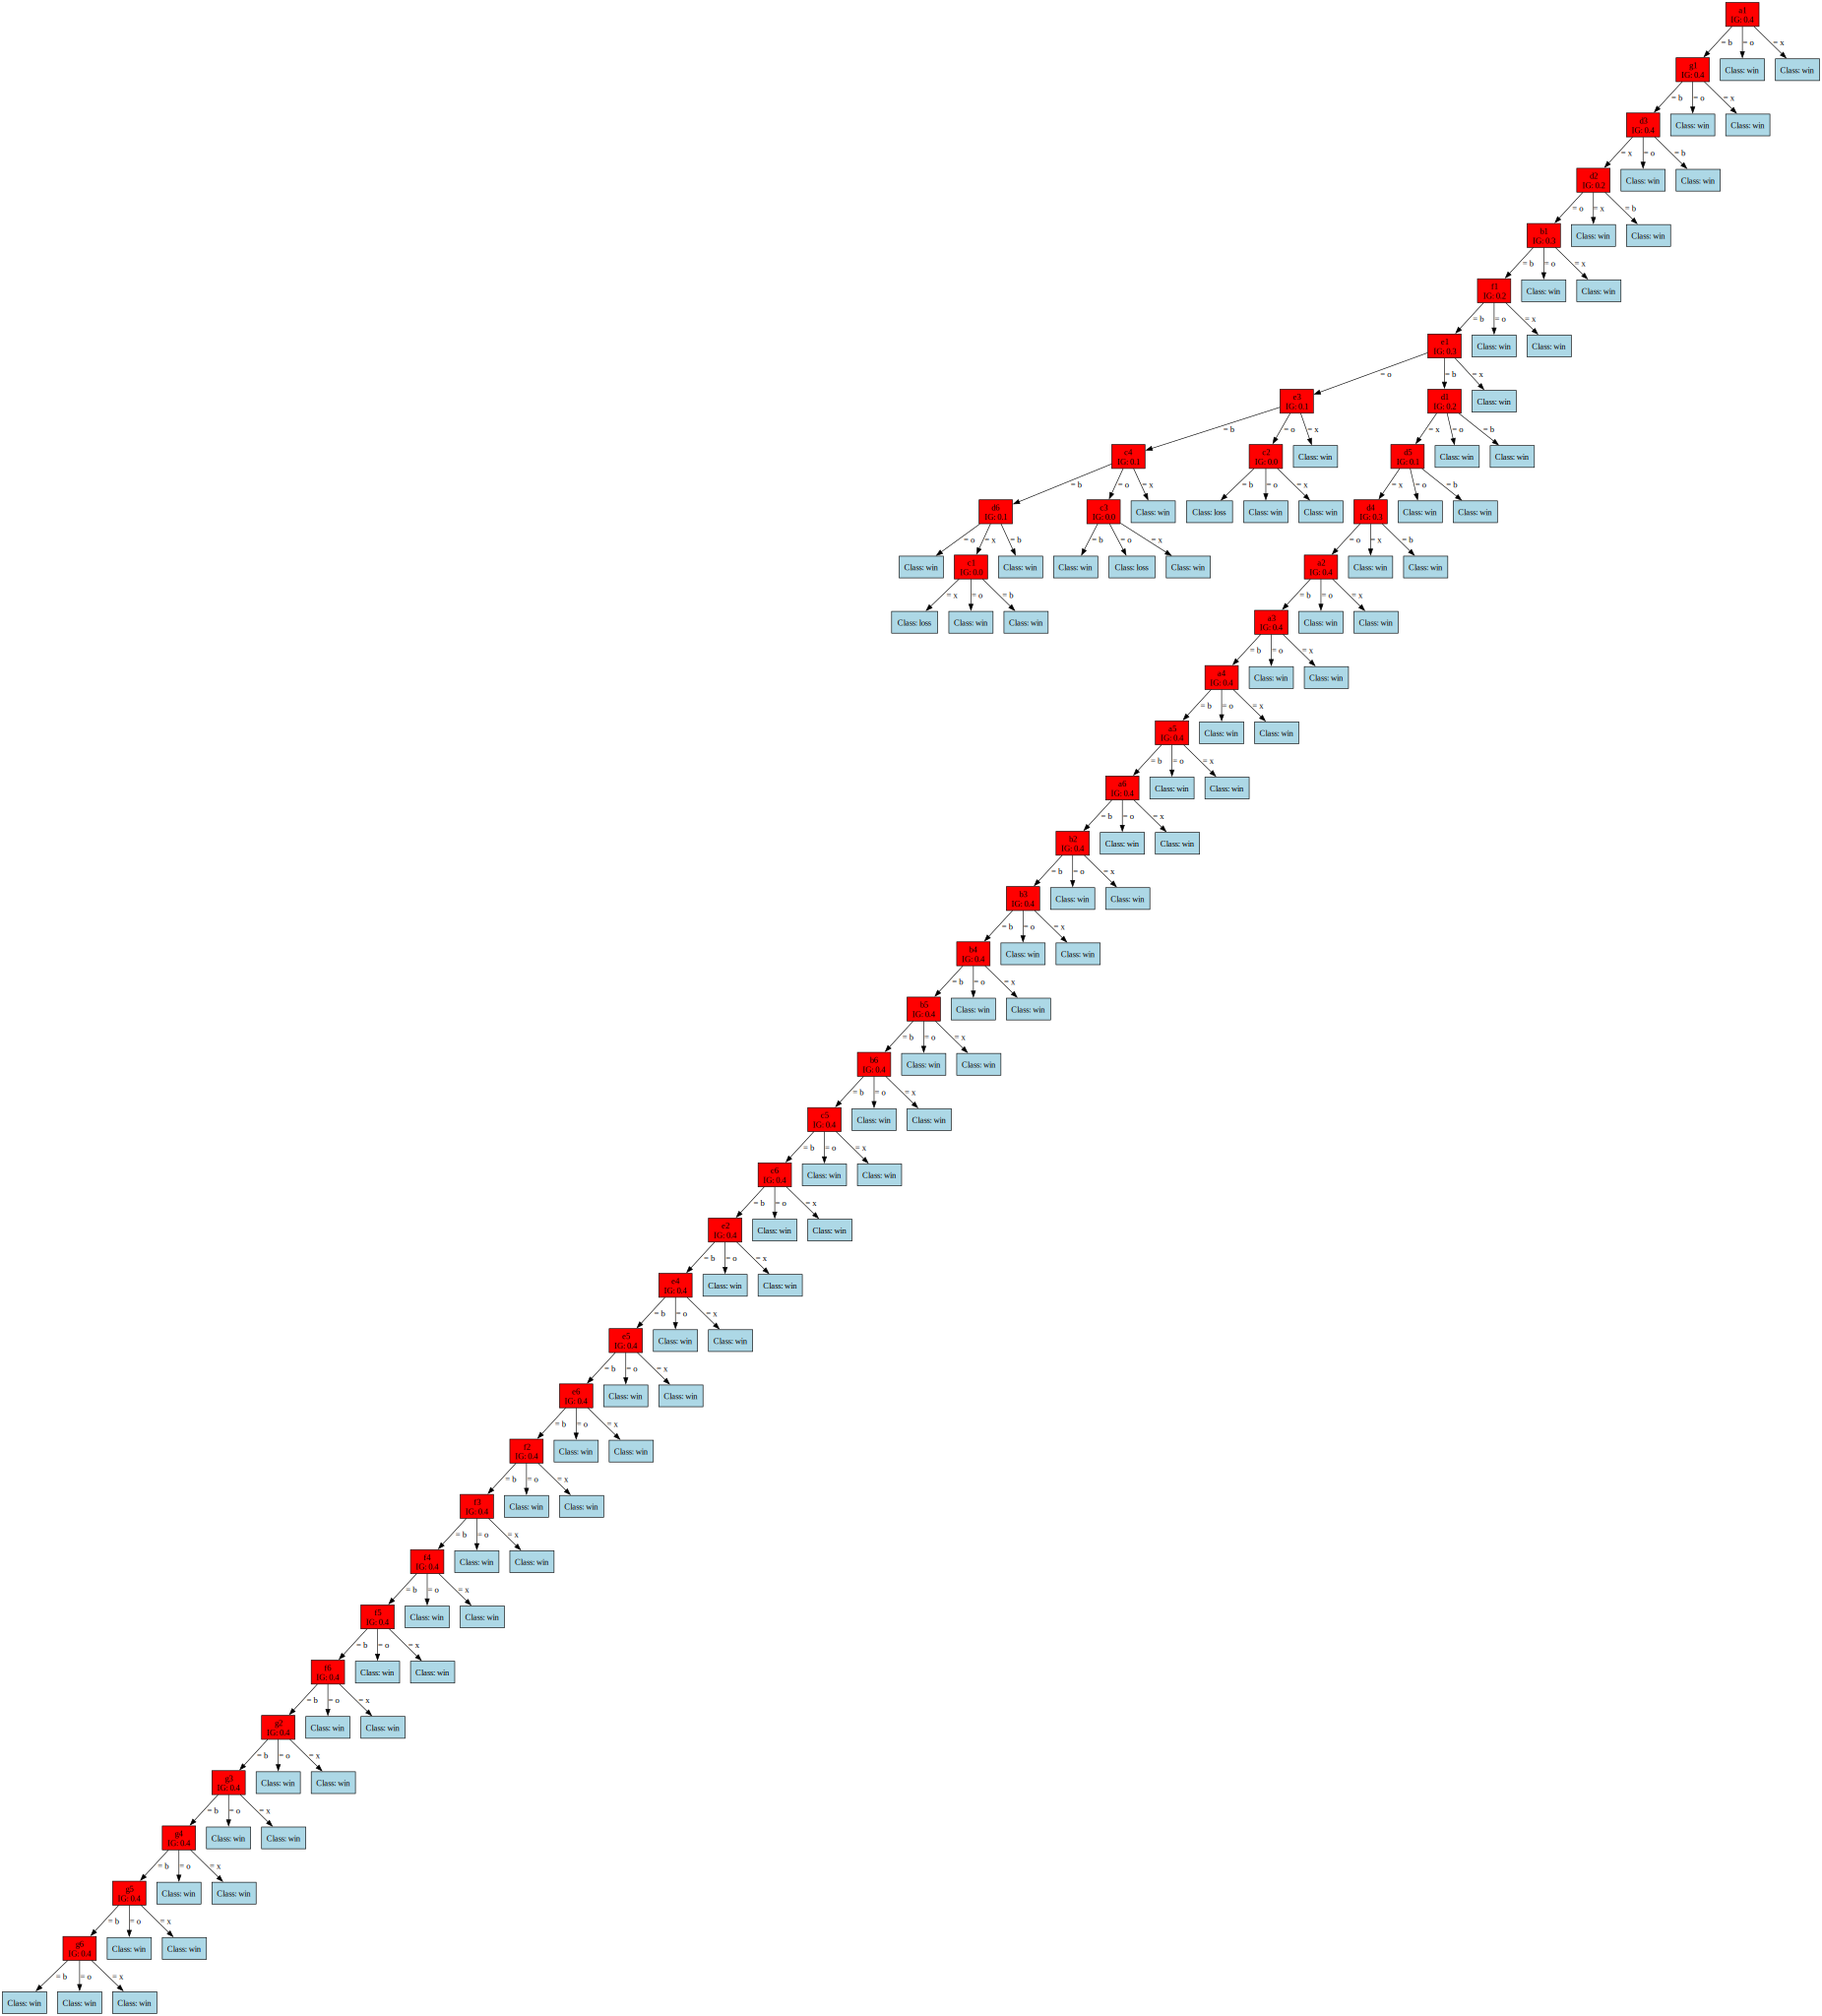

In [30]:
connect4_process = PreprocessData(dataset= connect4_df)
connect4_process.header()
connect4_process.prepare_dataset(n_classes= 3 , func= connect4_process.eq_interval_width)
connect4_process.stratify(0.1)
connect4_cod = connect4_process.codification

connect4_dt = DecisionTreeClassifier()
connect4_dt.fit(process= connect4_process, option= connect4_dt.max_gini)

connect4_dot = visualize_tree(connect4_dt.root, connect4_dt.target, connect4_cod)
connect4_dot.render('pngs/connect4_decision_tree', format='png', cleanup=True)
connect4_dot

Média das estatísticas para cada dataset. 

In [25]:
for process, name_dataset in {1: 'Restaurant'}.items():
    print(name_dataset + ': \n')
    for gain, name_gain in {1: 'Max_info_gain', 2: 'Max_gini'}.items():
        print(name_gain +': ')
        stats = Statistics()
        print(stats.evaluate_n_times(dataset= process, n= 20, n_classes= 2, f= 1, gain= gain, perc= 0.2))
        print()

Restaurant: 

Max_info_gain: 
precision    0.450000
recall       0.625000
accuracy     0.516667
dtype: float64

Max_gini: 
precision    0.483333
recall       0.675000
accuracy     0.500000
dtype: float64



Para o dataset "restaurant", é possível notar que para uma divisão de treinos 80%-20%, pelo baixo volume de dados, não possuí em geral boa precisão, entretanto entre info gain e gini, o gini possuí melhores resultados.

In [26]:
for process, name_dataset in {2: 'Weather', 3: 'Iris'}.items():
    print(name_dataset + ': \n')
    for func, name_func in {1: 'Eq_frequency', 2: 'Eq_interval_width'}.items():
        for gain, name_gain in {1: 'Max_info_gain', 2: 'Max_gini'}.items():
            for n in range(2,4):
                print(name_func + ', ' + name_gain + ', nº classes ' + str(n) + ': ')
                stats = Statistics()
                print(stats.evaluate_n_times(dataset= process, n= 20, n_classes= n, f= func, gain= gain, perc= 0.2))
                print()

Weather: 

Eq_frequency, Max_info_gain, nº classes 2: 
precision    0.85
recall       0.75
accuracy     0.80
dtype: float64

Eq_frequency, Max_info_gain, nº classes 3: 
precision    0.616667
recall       0.525000
accuracy     0.583333
dtype: float64

Eq_frequency, Max_gini, nº classes 2: 
precision    0.750000
recall       0.725000
accuracy     0.783333
dtype: float64

Eq_frequency, Max_gini, nº classes 3: 
precision    0.633333
recall       0.550000
accuracy     0.633333
dtype: float64

Eq_interval_width, Max_info_gain, nº classes 2: 
precision    0.550
recall       0.475
accuracy     0.600
dtype: float64

Eq_interval_width, Max_info_gain, nº classes 3: 
precision    0.475000
recall       0.400000
accuracy     0.583333
dtype: float64

Eq_interval_width, Max_gini, nº classes 2: 
precision    0.900000
recall       0.725000
accuracy     0.816667
dtype: float64

Eq_interval_width, Max_gini, nº classes 3: 
precision    0.666667
recall       0.625000
accuracy     0.616667
dtype: float64

Ir

No caso Weather, os melhores resultados foram obtidos, quando dividos em 2 classes, com "equal frequency", onde se mostrou indiferente se utilizar o info gain ou o gini.
Obs: foi notado um possível overfiting para o caso "Eq_interval_width, Max_gini, nº classes 2".


No caso iris, foi observado que quando os dados contínuos são dividos em 3 classes, obtemos "overfiting", portanto não são considerados uma boa divisão. Aos casos em que temos duas classes, tivemos os melhores resultados para divisão com "equal frequency", ser gini ou info gain se mostrou irrelevante.


In [27]:
for process, name_dataset in {4: 'Connect4'}.items():
    print(name_dataset + ': \n')
    for gain, name_gain in {1: 'Max_info_gain', 2: 'Max_gini'}.items():
        print(name_gain + ': ')
        stats = Statistics()
        print(stats.evaluate_n_times(dataset= process, n= 1, n_classes= 2, f= 1, gain= gain, perc= 0.15))
        print()


Connect4: 

Max_info_gain: 
precision    0.829205
recall       0.500200
accuracy     0.329405
dtype: float64

Max_gini: 
precision    0.524205
recall       0.507706
accuracy     0.341480
dtype: float64



Para o connect four, tivemos os melhores resultados separando 15% - 85% para treino, os valores de precisão são bastantes instáveis, onde foi possível num contexto geral obter os melhores resultados com o gini, entretanto por ser um dataset mais pesado, não temos assim tanta referência estatística.

Devido ao tamanho dos datasets do restaurant e do weather, 12 e 14 samples respectivamente, implementamos outro método de validação, o Leave One Out:

In [28]:
stats = Statistics()
stats.evaluate_loo(restaurant_process)

Precision: 0.5714285714285714
Recall: 0.6666666666666666
Accuracy: 0.5833333333333334
F1 Score: 0.6153846153846153
Confusion Matrix: 
 4|2
 -+-
 3|3


In [29]:
stats.evaluate_loo(weather_process)

Precision: 0.75
Recall: 0.6
Accuracy: 0.7857142857142857
F1 Score: 0.6666666666666665
Confusion Matrix: 
 3|2
 -+-
 1|8


Dessa forma é notável um grande aumento de performance, indicando que o problema talvez não seja da implementação da árvore mas sim do tamanho do dataset.

In [31]:
from copy import deepcopy

class Board:
    def __init__(self , player=None) -> None:
        self.board = []
        self.player = player

        for _ in range(6):
            row = []
            for _ in range(7):
                row.append('-')
            self.board.append(row)
        
    def __str__(self) -> str:
        string = ''
        for i in range(7):
            string += ''.join(str(i) + " ") 
        string+= '\n'
        
        for row in range(6):  
            string += ' '.join(self.board[row]) + '\n'
        return string
    
    def __eq__(self , other) -> bool:
        for row in range(6):
            if self.board[row] != other.getRow(row):
                return False
        return True    
    
    def getRow(self , row:int) -> list:
        return self.board[row]
    
    def getPos(self , row:int , col:int) -> str:
        return self.board[row][col]
    
    def setPos(self , row:int , col:int, player:str=None) -> None:
        if player:
            self.board[row][col] = player
        else:
            self.board[row][col] = self.player
            self.player = 'X' if self.player == 'O' else 'O'

    def resetBoard(self) -> None:
        for row in range(6):
            for col in range(7):
                self.board[row][col] = '-'

    def boardCopy(self):
        # se faz uma copia do tabuleiro no estado atual
        copy = Board()
        copy.board = deepcopy(self.board)
        copy.player = self.player
        return copy
    
    def finished(self) -> str | bool:
        for line in range(6):
            for col in range(7):
                if (line == 0):
                    row = self.getRow(line)
                    if (row.count('-') == 0): return 'Tie'
                    
                #horizontal
                if col <= 3:
                    if (self.getPos(line, col) == self.getPos(line, col + 1) == self.getPos(line, col + 2) == self.getPos(line, col + 3) and self.getPos(line, col) != '-'):
                        return self.getPos(line, col)
                #vertical
                if line <= 2:
                    if (self.getPos(line, col) == self.getPos(line + 1, col) == self.getPos(line + 2, col) == self.getPos(line + 3, col) and self.getPos(line, col) != '-'):
                        return self.getPos(line, col)
                #diagonal
                if (col <= 3 and line <= 2):
                    if (self.getPos(line, col) == self.getPos(line + 1, col + 1) == self.getPos(line + 2, col + 2) == self.getPos(line + 3, col + 3) and self.getPos(line, col) != '-'):
                        return self.getPos(line, col)
                #diagonal
                if (col <= 3 and line >= 3):
                    if (self.getPos(line, col) == self.getPos(line - 1, col + 1) == self.getPos(line - 2, col + 2) == self.getPos(line - 3, col + 3) and self.getPos(line, col) != '-'):
                        return self.getPos(line, col)
        return False
    
    def to_csv_by_columns(self) -> list:
        csv_list = []
        dic = {'-': 'b', 'X': 'x', 'O': 'o'}
        for col in range(7):
            for row in range(6):
                csv_list.append(dic.get(self.board[5 - row][col]))
        return csv_list

In [32]:
import random

def inputPlayer(letter:str) -> list: #pode ser removido, basta ver o pq de ser usado no min.py
    #retorna lista com a ordem do jogador
    if letter == 'X':
        return ['X', 'O']
    else:
        return ['O', 'X']

def askForFirstPlayer() -> list:
    while True:
        piece = input("Queres ser X, O or R? ")
        if piece.upper() == "X":
            return ['X', 'O']
        elif piece.upper() == "O":
            return ['O', 'X']
        elif piece.upper() == "R":
            m = random.randint(0, 1)
            return ['X', 'O'] if m == 0 else ['O', 'X']

def askForAlgorithm() -> int:
    while True:
        try:
            algorithm = int(input("Qual algoritmo queres? 1 - P vs P, 2 - A*, 3 - MC, 4 - Minimax : "))
        except ValueError:
            print("Tente inteiros. \n")
            continue

        if algorithm in range(1, 5, 1):
            return algorithm
        else:
            print('Tente um número de 1 a 4. \n')
        
def playAgain() -> bool:
    while True:
        play = input(("Queres jogar de novo? S ou N. : "))
        if play.upper() == 'S':
            return True
        elif play.upper() == 'N':
            return False
        else:
            print('Tente S ou N. \n')

def testMove(board:Board , col:int) -> int:
    #-1 se não é possível
    for i in range(6):
        if board.getPos(5-i, col) == "-":
            return 5 - i
    return -1

def possibleMoves(board:Board) -> list:
    acc = []
    for col in range(7):
        line = testMove(board, col)
        if line != -1:
            acc.append((line, col))
    return acc

def askForNextMove(board:Board) -> tuple:
    while True:
        try:
            col = int(input("Em qual coluna? "))
        except ValueError:
            print("Tente inteiros.")
            continue
        
        if col > 6 or col < 0:
            print("Fora das margens.")
        else:
            line = testMove(board, col)
            
            if line == -1:
                print("Coluna cheia.")
            else:
                board.setPos(line, col)
                return (line, col)

def winnerAi(board:Board , order:list) -> bool: 
    win = board.finished()
    if isinstance(win, str):
        if win == 'Tie':
            print('Empate.')
        elif win == order[0]:
            print('Ganhaste.')
        else:
            print('A IA ganhou.')
        return True
    return False


In [33]:
import pickle

with open('variables/models.pkl', 'rb') as f:
    p, dt = pickle.load(f)

def to_board(row: list):
    b = Board()
    dic = {'x': 'X', 'o': 'O', 'b': '-'}
    for i, player in enumerate(row):
        col = i // 6
        line = 5 - (i % 6)
        b.setPos(line, col, dic.get(player))
    l = [pos for sublist in b.board for pos in sublist]
    if l.count('O') >= l.count('X'): b.player = 'O'
    else: b.player = 'X'
    return b
        
def dt_decision(dt: DecisionTreeClassifier, board: Board) -> Board:
    indexes = dt.original_dataset.columns[:-1]
    
    #lista de todos os possiveis proximos moves ja em forma de lista
    next_moves = []
    for line, col in possibleMoves(board= board):
        copy = board.boardCopy()
        copy.setPos(line, col)
        next_moves.append(copy.to_csv_by_columns())
        
    #df com os proximos moves
    X = pd.DataFrame(data= next_moves, columns= indexes)
    predicts = dt.predict(X)
    
    #saber qual o index dos moves com wins ou draws
    win_indexes = []
    draw_indexes = []
    for idx, result in enumerate(predicts):
        if result == 'win':
            win_indexes.append(idx)
        elif result == 'draw':
            draw_indexes.append(idx)
    
    #preferencia win > draw > loss
    if len(win_indexes) > 0:
        idx = random.choice(win_indexes)
    elif len(draw_indexes) > 0:
        idx = random.choice(draw_indexes)
    else: idx = 0
    return to_board( next_moves[idx] )

def game(board: Board, order: list):
    print(board)
    while True:
        print('Tua vez.')
        askForNextMove(board)
        print(board)
        
        if winnerAi(board, order):
            return 
        
        #logica da arvore (?)
        board = dt_decision(dt, board)
        # print('A IA pôs uma peça na coluna ' + str(col) + '.')
        print(board)
        
        if winnerAi(board, order):
            return

def main():
    play = True
    while play:
        board = Board('O')
        board.resetBoard()
        game(board= board, order= ['O', 'X'])
        play = playAgain()

if __name__ == '__main__':
    main()

0 1 2 3 4 5 6 
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -

Tua vez.
0 1 2 3 4 5 6 
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - O - - -

0 1 2 3 4 5 6 
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - O X - -

Tua vez.
0 1 2 3 4 5 6 
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - O - - -
- - - O X - -

0 1 2 3 4 5 6 
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - O - - -
X - - O X - -

Tua vez.
0 1 2 3 4 5 6 
- - - - - - -
- - - - - - -
- - - - - - -
- - - O - - -
- - - O - - -
X - - O X - -

0 1 2 3 4 5 6 
- - - - - - -
- - - - - - -
- - - X - - -
- - - O - - -
- - - O - - -
X - - O X - -

Tua vez.
0 1 2 3 4 5 6 
- - - - - - -
- - - O - - -
- - - X - - -
- - - O - - -
- - - O - - -
X - - O X - -

0 1 2 3 4 5 6 
- - - - - - -
- - - O - - -
- - - X - - -
- - - O - - -
- - - O - - -
X - - O X X -

Tua vez.
0 1 2 3 4 5 6 
- - - - - - -
- - - O - - -
- - - X - - 

# Conclusão 

Dentre os datasets apresentados, foi possível notar que cada dataset possuía alguma particularidade, onde será destacado os principais desafios.

* Restaurant: Poucos samples e muitas features, pelo que foi um bom ponto de partida para criação da árvore, e ao selecionar o método de divisão de treino adequado, é alcançado resultados razoáveis nas estatísticas.

* Weather: Poucos samples e algumas features com valores contínuos. Para solucionar foi necessário se perceber mais de como se faz uma boa "discretização" dos valores contínuos, pelo que foi criada uma sólida classe de pré-processamento, e assim obter bons resultados.
        
* Íris: Boa quantidade de informação, classe target não binária, pelo que foi necessária recriar toda uma lógica onde melhor se adequava uma classe não binária. E como se utilizar a entropia para esse tipo de situação. Pelo que se foi conseguido bons resultados.

* Connect4: A maior dificuldade foi notada justamente em como se fazer a integração, entre uma id3 e um jogo externo, apesar de termos um volume gigantesco de samples, acredito que para o problema ainda são considerados poucas. O que na verdade não seria de grande valia pois mesmo com grande quantidade de informação, a decision tree e o A* estariam em uma competição acirrada entre os piores jogadores de connect 4.
